In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torchvision.utils import make_grid
from torchvision import models
from torchsummary import summary
from sklearn.model_selection import train_test_split

### Select device to train the model on

In [3]:
# function to get device
def get_device():
    # Check that MPS is available
    if not torch.backends.mps.is_available():
        if not torch.backends.mps.is_built():
            print("MPS not available because the current PyTorch install was not "
                  "built with MPS enabled.")
        else:
            print("MPS not available because the current MacOS version is not 12.3+ "
                  "and/or you do not have an MPS-enabled device on this machine.")
        return torch.device("cpu")

    else:
        mps_device = torch.device("mps")
        print("MPS selected.")
        return mps_device

device = get_device()

MPS selected.


In [99]:
# Fixed parameters
num_of_classes = 10
num_of_channels = 3

# Hyperparameters
learning_rate = 0.01
batch_size = 32
num_of_epochs = 25
loss_criterion = nn.CrossEntropyLoss()

### Read the dataset

In [100]:
transform_sequence = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Full training set
full_train_data = datasets.CIFAR10(
    root="dataset/", train=True, transform=transform_sequence, download=True)
full_train_load = DataLoader(
    dataset=full_train_data, batch_size=batch_size, shuffle=True)

# Generating reduced training and validation sets
train_data_count = int(len(full_train_data) * 0.8)
val_data_count = len(full_train_data) - train_data_count
train_data, val_data = random_split(full_train_data,
                                    [train_data_count, val_data_count],
                                    generator=torch.Generator().manual_seed(42))
train_load = DataLoader(
    dataset=train_data, batch_size=batch_size, shuffle=True)
val_load = DataLoader(
    dataset=val_data, batch_size=batch_size, shuffle=True)

# Test set
test_data = datasets.CIFAR10(
    root="dataset/", train=False, transform=transform_sequence, download=True)
test_load = DataLoader(
    dataset=test_data, batch_size=batch_size, shuffle=True)

Files already downloaded and verified
Files already downloaded and verified


### Create a baseline model

In [101]:
def get_activation_function(activation_function):
    # decide activation function
    actfn = nn.ReLU()
    if activation_function == "selu":
        actfn = nn.SELU()
    elif activation_function == "elu":
        actfn = nn.ELU()
    else:
        actfn = nn.ReLU()

    return actfn

def get_optimizer(model, optimizer, learning_rate):
    # decide optimizer
    opt = torch.optim.SGD(model.parameters(), lr=learning_rate)
    if optimizer == "adam":
        opt = torch.optim.Adam(model.parameters(), lr=learning_rate)
    elif optimizer == "nadam":
        torch.optim.NAdam(model.parameters(), lr=learning_rate)
    else:
        torch.optim.SGD(model.parameters(), lr=learning_rate)

    return opt

In [103]:
def generate_baseline_model(activation_function, optimizer, learning_rate):
    # decide activation function
    actfn = get_activation_function(activation_function)

    # Model creation
    baseline_model = nn.Sequential(
        nn.Conv2d(num_of_channels, 32, kernel_size=3, stride=1),
        actfn,
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.Conv2d(32, 64, kernel_size=3, stride=1),
        actfn,
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.Conv2d(64, 32, kernel_size=3, stride=1),
        actfn,
        nn.Flatten(),
        nn.Linear(32 * 4 * 4, 10),
        nn.Softmax(1)
    ).to(device)

    # decide optimizer
    opt = get_optimizer(baseline_model, optimizer, learning_rate)

    print(baseline_model)
    return baseline_model, opt

### Train the model

In [104]:
# Function to train and calculate loss and accuracy for one epoch
def train(epoch, train_load, model, optimizer):
    training_loss = 0
    training_accuracy = 0

    # Training mode
    model.train()
    for (X_train, y_train) in train_load:
        # Move features and labels to GPU (Metal - mps)
        X_train = X_train.to(device)
        y_train = y_train.to(device)

        # Forward
        training_scores = model(X_train)
        loss = loss_criterion(training_scores, y_train)
        training_loss += loss.item()
        training_accuracy += (training_scores.argmax(1) == y_train).sum().item()

        # Clear grads
        optimizer.zero_grad()

        # Backward
        loss.backward()

        # Gradient descent
        optimizer.step()

    # Calculate epoch loss and accuracy
    training_loss = training_loss / len(train_load)
    training_accuracy = training_accuracy / len(train_load.dataset)
    return training_loss, training_accuracy, model

def test(epoch, val_load, model):
    validation_loss = 0
    validation_accuracy = 0

    # Eval mode
    with torch.no_grad():
        model.eval()
        for (X_val, y_val) in val_load:
            # Move features and labels to GPU (Metal - mps)
            X_val = X_val.to(device)
            y_val = y_val.to(device)

            # Forward
            validation_scores = model(X_val)
            loss = loss_criterion(validation_scores, y_val)
            validation_loss += loss.item()
            validation_accuracy += (validation_scores.argmax(1) == y_val).sum().item()

    # Calculate epoch loss and accuracy
    validation_loss = validation_loss / len(val_load)
    validation_accuracy = validation_accuracy / len(val_load.dataset)
    return validation_loss, validation_accuracy

# Function to perform a full training run
def perform_training(model, optimizer, num_of_epochs, train_load, val_load, patience=3, early_stopping=False):
    # Train the model
    training_losses = []
    validation_losses = []
    training_accuracies = []
    validation_accuracies = []

    # Early stopping trackers
    trigger_times = 0
    current_val_accuracy = 0
    best_epoch = 0

    for epoch in range(num_of_epochs):
        # Train model and keep track of losses
        training_loss, training_accuracy, model = train(
            epoch, train_load, model, optimizer)
        validation_loss, validation_accuracy = test(epoch, val_load, model)

        # Track early stopping condition
        if validation_accuracy < current_val_accuracy:
            trigger_times += 1
        else:
            current_val_accuracy = validation_accuracy
            best_epoch = epoch
            trigger_times = 0

        if (trigger_times == patience) and early_stopping:
            print("Early stopped!")
            break

        training_losses.append(training_loss)
        validation_losses.append(validation_loss)
        training_accuracies.append(training_accuracy)
        validation_accuracies.append(validation_accuracy)

        print("Epoch", epoch + 1)
        display_results(training_loss, validation_loss,
                        training_accuracy, validation_accuracy)

    if (trigger_times == patience) and early_stopping:
        training_losses = training_losses[0:best_epoch + 1].copy()
        validation_losses = validation_losses[0:best_epoch + 1].copy()
        training_accuracies = training_accuracies[0:best_epoch + 1].copy()
        validation_accuracies = validation_accuracies[0:best_epoch + 1].copy()
    return (model, training_losses, validation_losses, training_accuracies, validation_accuracies)

# Function to display losses and accuracies (both training and validation)
def display_results(training_loss, validation_loss, training_accuracy, validation_accuracy):
    print("--------------------------------------")
    print("Train loss =", round(training_loss, 4))
    print("Validation loss =", round(validation_loss, 4))
    print("Training Acc =", round(training_accuracy, 4))
    print("Validation Acc =", round(validation_accuracy, 4))
    print("--------------------------------------")

# Function to show plots of losses and accuracies (both training and validation)
def show_plot(training_losses, validation_losses, training_accuracies, validation_accuracies):
    x_training = np.arange(1, len(training_losses) + 1)
    x_validation = np.arange(1, len(validation_losses) + 1)
    plt.plot(x_training, training_losses, marker='.', label="Training loss")
    plt.plot(x_training, validation_losses,
             marker='.', label="Validation loss")
    plt.plot(x_validation, training_accuracies,
             marker='.', label="Training accuracy")
    plt.plot(x_validation, validation_accuracies,
             marker='.', label="Validation accuracy")
    plt.legend()
    plt.xlabel("Epoch")
    plt.ylabel("Loss and Accuracy")
    plt.xticks(x_training)
    plt.show()

# Function to show images
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


### Display a batch of the train dataset

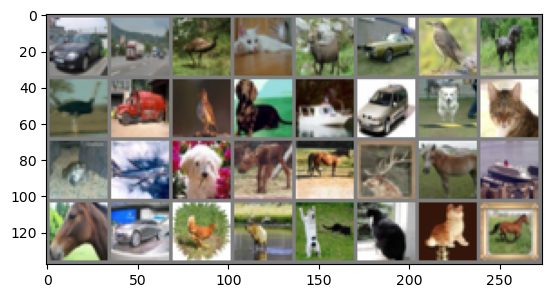

In [94]:
# get some random training images
dataiter = iter(train_load)
images, labels = dataiter.next()

# show images
imshow(make_grid(images))

### Train baseline model

In [84]:
'''
Do hyperparameter tuning for the baseline model with the hyperparameters being learning rate
and optimizer.
'''
results = []
optimizers = ["sgd", "adam"]
learning_rates = [0.001, 0.01, 0.1]
for opt in optimizers:
    for lr in learning_rates:
        model, optimizer = generate_baseline_model("relu", opt, lr)
        model_information = perform_training(
            model, optimizer, num_of_epochs, train_load, val_load, early_stopping=False)
        trained_model = model_information[0]
        training_losses = model_information[1]
        validation_losses = model_information[2]
        training_accuracies = model_information[3]
        validation_accuracies = model_information[4]
        results.append((training_accuracies[-1], validation_accuracies[-1],
                       training_losses[-1], validation_losses[-1], opt, lr))


Sequential(
  (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (4): ReLU()
  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1))
  (7): ReLU()
  (8): Flatten(start_dim=1, end_dim=-1)
  (9): Linear(in_features=512, out_features=10, bias=True)
  (10): Softmax(dim=1)
)
Epoch 1
--------------------------------------
Train loss = 2.3026
Validation loss = 2.3026
Training Acc = 0.0982
Validation Acc = 0.1026
--------------------------------------
Epoch 2
--------------------------------------
Train loss = 2.3025
Validation loss = 2.3025
Training Acc = 0.1045
Validation Acc = 0.1063
--------------------------------------
Epoch 3
--------------------------------------
Train loss = 2.3025
Validation loss = 2.3024
Training Acc = 0.1104
Validation Acc = 0.1

In [95]:
# Visualize the hyperparameter tuning results for the baseline model
results.sort(reverse=True)
results_df = pd.DataFrame(results)
results_df = results_df.rename(
    columns={0: "Train Acc.", 1: "Val Acc.", 2: "Train loss", 3: "Val loss", 4: "Optimizer", 5: "lr"})
results_df

,Train Acc.,Val Acc.,Train loss,Val loss,Optimizer,lr
0,0.690925,0.6215,1.768589,1.838056,adam,0.001
1,0.655750,0.6126,1.803487,1.847853,sgd,0.100
2,0.503125,0.4989,1.957184,1.960556,sgd,0.010
3,0.130050,0.1315,2.286124,2.284305,sgd,0.001
4,0.100925,0.0963,2.360225,2.364904,adam,0.010
5,0.099400,0.1024,2.361750,2.358714,adam,0.100


In [105]:
'''
Train the baseline model for 25 epochs with a
batch size of 32 (with Adam as the optimizer, lr=0.001)
'''
model, optimizer = generate_baseline_model("relu", "adam", 0.001)
model_information = perform_training(
    model, optimizer, num_of_epochs, train_load, val_load, early_stopping=True)
trained_model = model_information[0]
training_losses = model_information[1]
validation_losses = model_information[2]
training_accuracies = model_information[3]
validation_accuracies = model_information[4]


Sequential(
  (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (4): ReLU()
  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1))
  (7): ReLU()
  (8): Flatten(start_dim=1, end_dim=-1)
  (9): Linear(in_features=512, out_features=10, bias=True)
  (10): Softmax(dim=1)
)
Epoch 1
--------------------------------------
Train loss = 2.0919
Validation loss = 2.0284
Training Acc = 0.3607
Validation Acc = 0.4245
--------------------------------------
Epoch 2
--------------------------------------
Train loss = 1.9963
Validation loss = 1.9992
Training Acc = 0.4594
Validation Acc = 0.4549
--------------------------------------
Epoch 3
--------------------------------------
Train loss = 1.9539
Validation loss = 1.9422
Training Acc = 0.5033
Validation Acc = 0.5

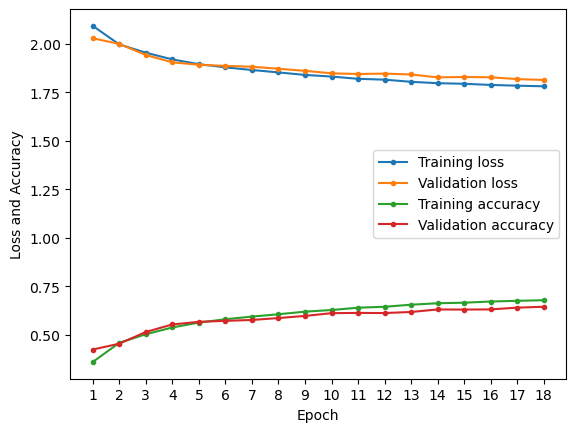

In [106]:
# Plot graph
show_plot(training_losses, validation_losses,
          training_accuracies, validation_accuracies)

### Model 1

In [15]:
# Model with no regularization
def generate_model1(activation_function, optimizer, learning_rate):
    actfn = get_activation_function(activation_function)

    # Model creation
    model = nn.Sequential(
        nn.Conv2d(num_of_channels, 128, kernel_size=3, stride=1, padding=1),
        actfn,
        nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
        actfn,
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.Conv2d(256, 128, kernel_size=3, stride=1, padding=1),
        actfn,
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.Conv2d(128, 16, kernel_size=3, stride=1, padding=1),
        actfn,
        nn.Flatten(),
        nn.Linear(16 * 8 * 8, 10),
        nn.Softmax(1)
    ).to(device)

    opt = get_optimizer(model, optimizer, learning_rate)
    print(model)
    return model, opt


# Model 1 with regularization.
def generate_model1_reg(activation_function, optimizer, learning_rate):
    actfn = get_activation_function(activation_function)

    # Model creation
    model = nn.Sequential(
        nn.Conv2d(num_of_channels, 128, kernel_size=3, stride=1, padding=1),
        actfn,
        nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(256),
        actfn,
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.Conv2d(256, 128, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(128),
        actfn,
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.Conv2d(128, 16, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(16),
        actfn,
        nn.Flatten(),
        nn.Linear(16 * 8 * 8, 10),
        nn.Softmax(1)
    ).to(device)

    opt = get_optimizer(model, optimizer, learning_rate)
    print(model)
    return model, opt


### Experiments with Model 1

In [21]:
'''
lr = 0.001, optimizer = adam, actfn = relu performed best out of several combinations of lr = 0.1,
0.01, 0.001, optimizer = sgd, adam, actfn = relu and elu.
'''
model1, optimizer1 = generate_model1("relu", "adam", 0.001)
model_information1 = perform_training(
    model1, optimizer1, 25, train_load, val_load, early_stopping=True, patience=4)
trained_model1 = model_information1[0]
training_losses1 = model_information1[1]
validation_losses1 = model_information1[2]
training_accuracies1 = model_information1[3]
validation_accuracies1 = model_information1[4]


Sequential(
  (0): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU()
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU()
  (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (8): Conv2d(128, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (9): ReLU()
  (10): Flatten(start_dim=1, end_dim=-1)
  (11): Linear(in_features=1024, out_features=10, bias=True)
  (12): Softmax(dim=1)
)
Epoch 1
--------------------------------------
Train loss = 2.1902
Validation loss = 2.356
Training Acc = 0.2647
Validation Acc = 0.1042
--------------------------------------
Epoch 2
--------------------------------------
Train loss = 2.2867
Validation loss = 2.3311
Training Acc = 0.1742
Validation Acc = 0.13
--------------------------------

In [88]:
summary(model1)

Layer (type:depth-idx)                   Param #
├─Conv2d: 1-1                            3,584
├─ReLU: 1-2                              --
├─Conv2d: 1-3                            295,168
├─MaxPool2d: 1-4                         --
├─Conv2d: 1-5                            295,040
├─MaxPool2d: 1-6                         --
├─Conv2d: 1-7                            18,448
├─Flatten: 1-8                           --
├─Linear: 1-9                            10,250
├─Softmax: 1-10                          --
Total params: 622,490
Trainable params: 622,490
Non-trainable params: 0


Layer (type:depth-idx)                   Param #
├─Conv2d: 1-1                            3,584
├─ReLU: 1-2                              --
├─Conv2d: 1-3                            295,168
├─MaxPool2d: 1-4                         --
├─Conv2d: 1-5                            295,040
├─MaxPool2d: 1-6                         --
├─Conv2d: 1-7                            18,448
├─Flatten: 1-8                           --
├─Linear: 1-9                            10,250
├─Softmax: 1-10                          --
Total params: 622,490
Trainable params: 622,490
Non-trainable params: 0

In [16]:
'''
lr = 0.001, optimizer = adam, actfn = relu performed best out of several combinations of lr = 0.1,
0.01, 0.001, optimizer = sgd, adam, actfn = relu and elu.
'''
model1_reg, optimizer1_reg = generate_model1_reg("relu", "adam", 0.001)
model_information1_reg = perform_training(
    model1_reg, optimizer1_reg, 25, train_load, val_load, early_stopping=True, patience=4)
trained_model1_reg = model_information1_reg[0]
training_losses1_reg = model_information1_reg[1]
validation_losses1_reg = model_information1_reg[2]
training_accuracies1_reg = model_information1_reg[3]
validation_accuracies1_reg = model_information1_reg[4]


Sequential(
  (0): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (4): ReLU()
  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (8): ReLU()
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (12): ReLU()
  (13): Flatten(start_dim=1, end_dim=-1)
  (14): Linear(in_features=1024, out_features=10, bias=True)
  (15): Softmax(dim=1)
)
Epoch 1
--------------------------------------
Train loss = 1.9604
Validation 

In [89]:
summary(model1_reg)

Layer (type:depth-idx)                   Param #
├─Conv2d: 1-1                            3,584
├─ReLU: 1-2                              --
├─Conv2d: 1-3                            295,168
├─BatchNorm2d: 1-4                       512
├─MaxPool2d: 1-5                         --
├─Conv2d: 1-6                            295,040
├─BatchNorm2d: 1-7                       256
├─MaxPool2d: 1-8                         --
├─Conv2d: 1-9                            18,448
├─BatchNorm2d: 1-10                      32
├─Flatten: 1-11                          --
├─Linear: 1-12                           10,250
├─Softmax: 1-13                          --
Total params: 623,290
Trainable params: 623,290
Non-trainable params: 0


Layer (type:depth-idx)                   Param #
├─Conv2d: 1-1                            3,584
├─ReLU: 1-2                              --
├─Conv2d: 1-3                            295,168
├─BatchNorm2d: 1-4                       512
├─MaxPool2d: 1-5                         --
├─Conv2d: 1-6                            295,040
├─BatchNorm2d: 1-7                       256
├─MaxPool2d: 1-8                         --
├─Conv2d: 1-9                            18,448
├─BatchNorm2d: 1-10                      32
├─Flatten: 1-11                          --
├─Linear: 1-12                           10,250
├─Softmax: 1-13                          --
Total params: 623,290
Trainable params: 623,290
Non-trainable params: 0

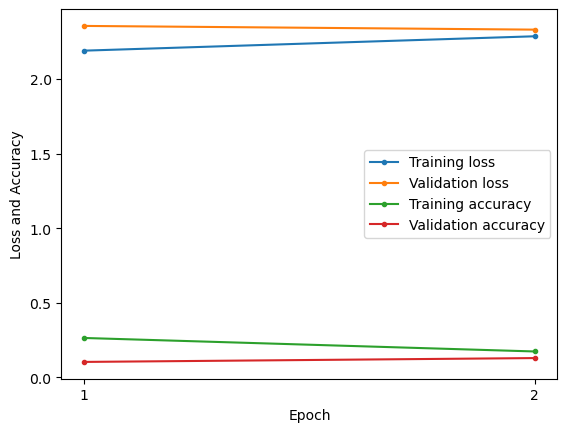

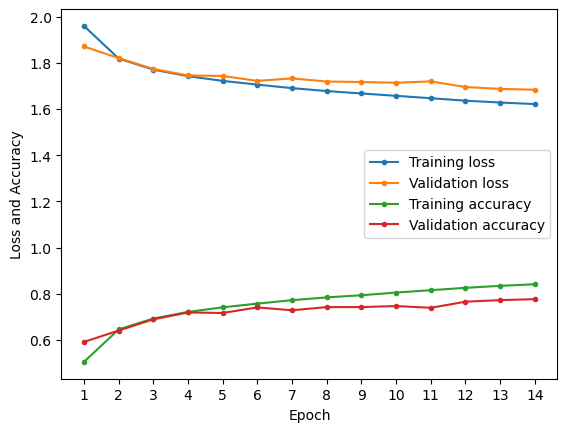

In [107]:
# Plot graph for model 1
show_plot(training_losses1, validation_losses1,
          training_accuracies1, validation_accuracies1)
# Plot graph for model 1 with regularization techniques like batch-norm.
show_plot(training_losses1_reg, validation_losses1_reg,
          training_accuracies1_reg, validation_accuracies1_reg)

### Model 2

In [23]:
def generate_model2(activation_function, optimizer, learning_rate):
    actfn = get_activation_function(activation_function)

    # Model creation
    model = nn.Sequential(
        nn.Conv2d(num_of_channels, 512, kernel_size=3, stride=1, padding=1),
        actfn,
        nn.Conv2d(512, 128, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(128),
        actfn,
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(64),
        actfn,
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.Conv2d(64, 16, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(16),
        actfn,
        nn.Flatten(),
        nn.Linear(16 * 8 * 8, 64),
        nn.ReLU(),
        nn.Dropout(0.5),
        nn.Linear(64, 10),
        nn.Softmax(1)
    ).to(device)

    opt = get_optimizer(model, optimizer, learning_rate)
    print(model)
    return model, opt


def generate_model2_ver2(activation_function, optimizer, learning_rate):
    actfn = get_activation_function(activation_function)

    # Model creation
    model = nn.Sequential(
        nn.Conv2d(num_of_channels, 512, kernel_size=3, stride=1, padding=1),
        actfn,
        nn.Conv2d(512, 128, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(128),
        actfn,
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(64),
        actfn,
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.Conv2d(64, 16, kernel_size=3, stride=1, padding=1),
        nn.Dropout(0.25),
        actfn,
        nn.Flatten(),
        nn.Linear(16 * 8 * 8, 10),
        nn.Softmax(1)
    ).to(device)

    opt = get_optimizer(model, optimizer, learning_rate)
    print(model)
    return model, opt


### Experiments with the second model

In [24]:
'''
lr = 0.001, optimizer = adam, actfn = relu performed best out of several combinations of lr = 0.1,
0.01, 0.001, optimizer = sgd, adam, actfn = relu and elu.
'''
model2, optimizer2 = generate_model2("relu", "adam", 0.001)
model_information2 = perform_training(
    model2, optimizer2, 25, train_load, val_load, early_stopping=True, patience=4)
trained_model2 = model_information2[0]
training_losses2 = model_information2[1]
validation_losses2 = model_information2[2]
training_accuracies2 = model_information2[3]
validation_accuracies2 = model_information2[4]


Sequential(
  (0): Conv2d(3, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): Conv2d(512, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (4): ReLU()
  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (7): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (8): ReLU()
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(64, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (12): ReLU()
  (13): Flatten(start_dim=1, end_dim=-1)
  (14): Linear(in_features=1024, out_features=64, bias=True)
  (15): ReLU()
  (16): Dropout(p=0.5, inplace=False)
  (17): Linear(in_features=64, out_features=10, bias=

In [90]:
summary(model2)

Layer (type:depth-idx)                   Param #
├─Conv2d: 1-1                            14,336
├─ReLU: 1-2                              --
├─Conv2d: 1-3                            589,952
├─BatchNorm2d: 1-4                       256
├─MaxPool2d: 1-5                         --
├─Conv2d: 1-6                            73,792
├─BatchNorm2d: 1-7                       128
├─MaxPool2d: 1-8                         --
├─Conv2d: 1-9                            9,232
├─BatchNorm2d: 1-10                      32
├─Flatten: 1-11                          --
├─Linear: 1-12                           65,600
├─ReLU: 1-13                             --
├─Dropout: 1-14                          --
├─Linear: 1-15                           650
├─Softmax: 1-16                          --
Total params: 753,978
Trainable params: 753,978
Non-trainable params: 0


Layer (type:depth-idx)                   Param #
├─Conv2d: 1-1                            14,336
├─ReLU: 1-2                              --
├─Conv2d: 1-3                            589,952
├─BatchNorm2d: 1-4                       256
├─MaxPool2d: 1-5                         --
├─Conv2d: 1-6                            73,792
├─BatchNorm2d: 1-7                       128
├─MaxPool2d: 1-8                         --
├─Conv2d: 1-9                            9,232
├─BatchNorm2d: 1-10                      32
├─Flatten: 1-11                          --
├─Linear: 1-12                           65,600
├─ReLU: 1-13                             --
├─Dropout: 1-14                          --
├─Linear: 1-15                           650
├─Softmax: 1-16                          --
Total params: 753,978
Trainable params: 753,978
Non-trainable params: 0

In [26]:
'''
lr = 0.001, optimizer = adam, actfn = relu performed best out of several combinations of lr = 0.1,
0.01, 0.001, optimizer = sgd, adam, actfn = relu and elu.
'''
model2_ver2, optimizer2_ver2 = generate_model2_ver2("relu", "adam", 0.001)
model_information2_ver2 = perform_training(
    model2_ver2, optimizer2_ver2, 25, train_load, val_load, early_stopping=True, patience=4)
trained_model2_ver2 = model_information2_ver2[0]
training_losses2_ver2 = model_information2_ver2[1]
validation_losses2_ver2 = model_information2_ver2[2]
training_accuracies2_ver2 = model_information2_ver2[3]
validation_accuracies2_ver2 = model_information2_ver2[4]

Sequential(
  (0): Conv2d(3, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): Conv2d(512, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (4): ReLU()
  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (7): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (8): ReLU()
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(64, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): Dropout(p=0.25, inplace=False)
  (12): ReLU()
  (13): Flatten(start_dim=1, end_dim=-1)
  (14): Linear(in_features=1024, out_features=10, bias=True)
  (15): Softmax(dim=1)
)
Epoch 1
--------------------------------------
Train loss = 2.0471
Validation loss = 1.9843
Training Acc = 0.4065
Validation Acc =

In [91]:
summary(model2_ver2)

Layer (type:depth-idx)                   Param #
├─Conv2d: 1-1                            14,336
├─ReLU: 1-2                              --
├─Conv2d: 1-3                            589,952
├─BatchNorm2d: 1-4                       256
├─MaxPool2d: 1-5                         --
├─Conv2d: 1-6                            73,792
├─BatchNorm2d: 1-7                       128
├─MaxPool2d: 1-8                         --
├─Conv2d: 1-9                            9,232
├─Dropout: 1-10                          --
├─Flatten: 1-11                          --
├─Linear: 1-12                           10,250
├─Softmax: 1-13                          --
Total params: 697,946
Trainable params: 697,946
Non-trainable params: 0


Layer (type:depth-idx)                   Param #
├─Conv2d: 1-1                            14,336
├─ReLU: 1-2                              --
├─Conv2d: 1-3                            589,952
├─BatchNorm2d: 1-4                       256
├─MaxPool2d: 1-5                         --
├─Conv2d: 1-6                            73,792
├─BatchNorm2d: 1-7                       128
├─MaxPool2d: 1-8                         --
├─Conv2d: 1-9                            9,232
├─Dropout: 1-10                          --
├─Flatten: 1-11                          --
├─Linear: 1-12                           10,250
├─Softmax: 1-13                          --
Total params: 697,946
Trainable params: 697,946
Non-trainable params: 0

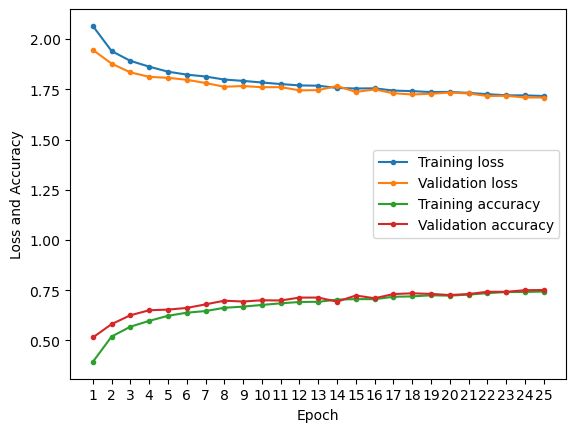

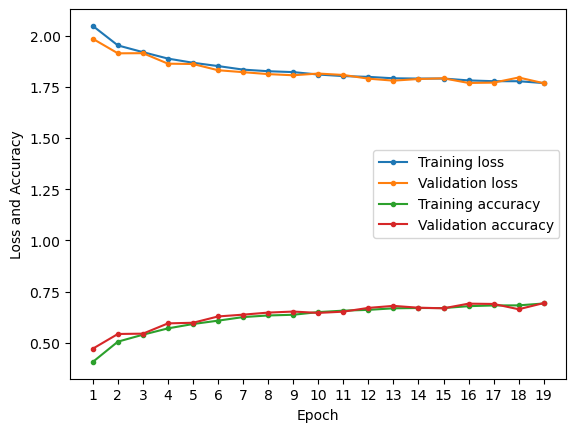

In [93]:
# Plot graph for model 2
show_plot(training_losses2, validation_losses2,
          training_accuracies2, validation_accuracies2)
# Plot graph for model 2 version 2
show_plot(training_losses2_ver2, validation_losses2_ver2,
          training_accuracies2_ver2, validation_accuracies2_ver2)

### Augmenting the dataset

In [28]:
augment_transform_sequence = transforms.Compose([
    # transforms.CenterCrop((24, 24)),
    transforms.RandomHorizontalFlip(0.5),
    transforms.RandomVerticalFlip(0.5),
    transforms.GaussianBlur(kernel_size=(5, 5)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Full training set augmented
full_train_data_augmented = datasets.CIFAR10(
    root="dataset_augmented/", train=True, transform=augment_transform_sequence, download=True)

# Split dataset into train and validation
train_indices, _ = train_test_split(
    list(range(len(full_train_data_augmented.targets))), test_size=0.8, stratify=full_train_data_augmented.targets)
train_dataset_extra = torch.utils.data.Subset(full_train_data_augmented, train_indices)
train_data_augmented = torch.utils.data.ConcatDataset(
    [train_dataset_extra, train_data])

# Create augmented train loader
train_load_augmented = DataLoader(
    dataset=train_data_augmented, batch_size=batch_size, shuffle=True)

print("Lenth of augmented train data =", len(train_data_augmented))


Files already downloaded and verified
Lenth of augmented train data = 50000


### Display augmented dataset batch

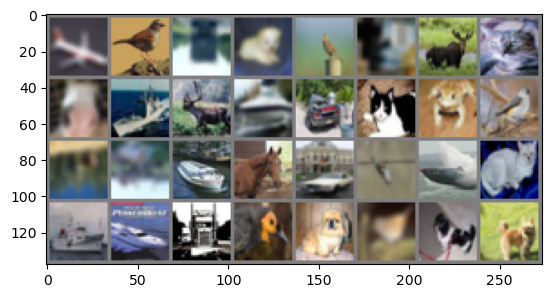

In [92]:
# get some random training images
dataiter = iter(train_load_augmented)
images, labels = dataiter.next()

# show images
imshow(make_grid(images))

### Train model 1 on the augmented dataset

In [30]:
'''
lr = 0.001, optimizer = adam, actfn = relu performed best out of several combinations of lr = 0.1,
0.01, 0.001, optimizer = sgd, adam, actfn = relu and elu.
'''
model1_aug, optimizer1_aug = generate_model1("relu", "adam", 0.001)
model_information1_aug = perform_training(
    model1_aug, optimizer1_aug, 25, train_load_augmented, val_load, early_stopping=True, patience=4)
trained_model1_aug = model_information1_aug[0]
training_losses1_aug = model_information1_aug[1]
validation_losses1_aug = model_information1_aug[2]
training_accuracies1_aug = model_information1_aug[3]
validation_accuracies1_aug = model_information1_aug[4]


Sequential(
  (0): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU()
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU()
  (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (8): Conv2d(128, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (9): ReLU()
  (10): Flatten(start_dim=1, end_dim=-1)
  (11): Linear(in_features=1024, out_features=10, bias=True)
  (12): Softmax(dim=1)
)
Epoch 1
--------------------------------------
Train loss = 2.2618
Validation loss = 2.2132
Training Acc = 0.1923
Validation Acc = 0.2433
--------------------------------------
Epoch 2
--------------------------------------
Train loss = 2.2019
Validation loss = 2.1651
Training Acc = 0.2574
Validation Acc = 0.2956
-----------------------------

### Train model 1 with regularization on the augmented dataset

In [31]:
'''
lr = 0.001, optimizer = adam, actfn = relu performed best out of several combinations of lr = 0.1,
0.01, 0.001, optimizer = sgd, adam, actfn = relu and elu.
'''
model1_reg_aug, optimizer1_reg_aug = generate_model1_reg("relu", "adam", 0.001)
model_information1_reg_aug = perform_training(
    model1_reg_aug, optimizer1_reg_aug, 25, train_load_augmented, val_load, early_stopping=True, patience=4)
trained_model1_reg_aug = model_information1_reg_aug[0]
training_losses1_reg_aug = model_information1_reg_aug[1]
validation_losses1_reg_aug = model_information1_reg_aug[2]
training_accuracies1_reg_aug = model_information1_reg_aug[3]
validation_accuracies1_reg_aug = model_information1_reg_aug[4]


Sequential(
  (0): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (4): ReLU()
  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (8): ReLU()
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (12): ReLU()
  (13): Flatten(start_dim=1, end_dim=-1)
  (14): Linear(in_features=1024, out_features=10, bias=True)
  (15): Softmax(dim=1)
)
Epoch 1
--------------------------------------
Train loss = 1.9898
Validation 

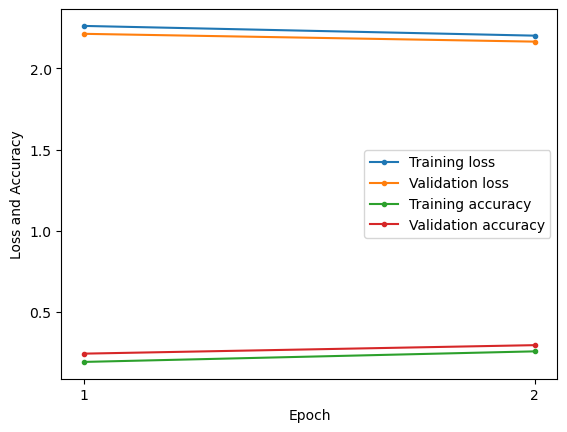

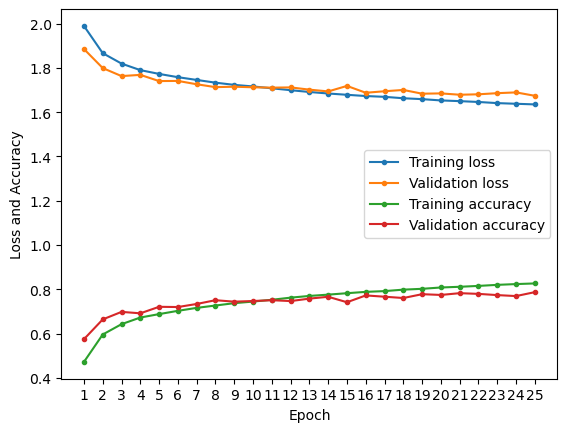

In [32]:
show_plot(training_losses1_aug, validation_losses1_aug,
          training_accuracies1_aug, validation_accuracies1_aug)
show_plot(training_losses1_reg_aug, validation_losses1_reg_aug,
          training_accuracies1_reg_aug, validation_accuracies1_reg_aug)

### Training model 2 on the augmented dataset

In [33]:
'''
lr = 0.001, optimizer = adam, actfn = relu performed best out of several combinations of lr = 0.1,
0.01, 0.001, optimizer = sgd, adam, actfn = relu and elu.
'''
model2_aug, optimizer2_aug = generate_model2("relu", "adam", 0.001)
model_information2_aug = perform_training(
    model2_aug, optimizer2_aug, 25, train_load, val_load, early_stopping=True, patience=4)
trained_model2_aug = model_information2_aug[0]
training_losses2_aug = model_information2_aug[1]
validation_losses2_aug = model_information2_aug[2]
training_accuracies2_aug = model_information2_aug[3]
validation_accuracies2_aug = model_information2_aug[4]

Sequential(
  (0): Conv2d(3, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): Conv2d(512, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (4): ReLU()
  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (7): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (8): ReLU()
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(64, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (12): ReLU()
  (13): Flatten(start_dim=1, end_dim=-1)
  (14): Linear(in_features=1024, out_features=64, bias=True)
  (15): ReLU()
  (16): Dropout(p=0.5, inplace=False)
  (17): Linear(in_features=64, out_features=10, bias=

### Training model 2 version 2 on the augmented dataset

In [38]:
'''
lr = 0.001, optimizer = adam, actfn = relu performed best out of several combinations of lr = 0.1,
0.01, 0.001, optimizer = sgd, adam, actfn = relu and elu.
'''
model2_ver2_aug, optimizer2_ver2_aug = generate_model2_ver2("relu", "adam", 0.001)
model_information2_ver2_aug = perform_training(
    model2_ver2_aug, optimizer2_ver2_aug, 25, train_load, val_load, early_stopping=True, patience=4)
trained_model2_ver2_aug = model_information2_ver2_aug[0]
training_losses2_ver2_aug = model_information2_ver2_aug[1]
validation_losses2_ver2_aug = model_information2_ver2_aug[2]
training_accuracies2_ver2_aug = model_information2_ver2_aug[3]
validation_accuracies2_ver2_aug = model_information2_ver2_aug[4]


Sequential(
  (0): Conv2d(3, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): Conv2d(512, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (4): ReLU()
  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (7): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (8): ReLU()
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(64, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): Dropout(p=0.25, inplace=False)
  (12): ReLU()
  (13): Flatten(start_dim=1, end_dim=-1)
  (14): Linear(in_features=1024, out_features=10, bias=True)
  (15): Softmax(dim=1)
)
Epoch 1
--------------------------------------
Train loss = 2.0721
Validation loss = 1.991
Training Acc = 0.3818
Validation Acc = 

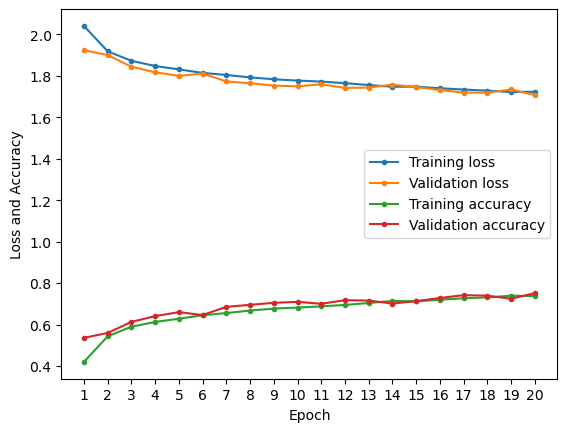

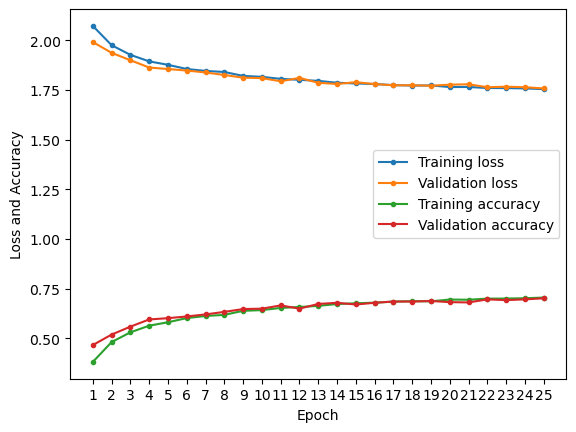

In [39]:
show_plot(training_losses2_aug, validation_losses2_aug,
          training_accuracies2_aug, validation_accuracies2_aug)
show_plot(training_losses2_ver2_aug, validation_losses2_ver2_aug,
          training_accuracies2_ver2_aug, validation_accuracies2_ver2_aug)

### Testing the best model(s) on the test set

In [56]:
# Test performance of model 1 with regularization
test_loss_model1_reg, test_accuracy_model1_reg = test(0, test_load, model1_reg)
print("t.a = ", test_accuracy_model1_reg)
print("t.l = ", test_loss_model1_reg)

t.a =  0.7705
t.l =  1.6877763541742636


In [57]:
# Test performance of model 2
test_loss_model2, test_accuracy_model2 = test(0, test_load, model2)
print("t.a = ", test_accuracy_model2)
print("t.l = ", test_loss_model2)


t.a =  0.7545
t.l =  1.7070344705551197


In [60]:
# Test performance of model 1 with regularization (with augmented dataset)
test_loss_model1_reg_aug, test_accuracy_model1_reg_aug = test(0, test_load, model1_reg_aug)
print("t.a = ", test_accuracy_model1_reg_aug)
print("t.l = ", test_loss_model1_reg_aug)

t.a =  0.7804
t.l =  1.6780169314850633


In [86]:
# Test performance of model 2 (with augmented dataset)
test_loss_model2_aug, test_accuracy_model2_aug = test(
    0, test_load, model2_aug)
print("t.a = ", test_accuracy_model2_aug)
print("t.l = ", test_loss_model2_aug)

t.a =  0.7521
t.l =  1.7086261537509224
